# Using Augraphy in Tensorflow deep learning pipeline augmentation process.

In this example, a classifier will be trained in [Tensorflow](https://www.tensorflow.org/) deep learning framework to classify between clean and dirty document images. 

[Augraphy](https://github.com/sparkfish/augraphy) will be used to augment the clean images and generate the dirty set of images.

[Transfer learning](https://www.tensorflow.org/tutorials/images/transfer_learning) is applied on a [Resnet](https://pytorch.org/hub/pytorch_vision_resnet/) model to further fine tune it in classifying the images into "dirty" and "clean".

 The image dataset is extracted from a Kaggle document denoising competition: [Denoising ShabbyPages](https://www.kaggle.com/competitions/denoising-shabby-pages).

1. The first step is to download the image dataset. We are using [gdown](https://github.com/wkentaro/gdown) to download the data here.

In [ ]:
# download and unzip document image data

!gdown --id 1uJPavzL7K3FFr9MEfZbdX3SNa1bGEdPu
!unzip shabby_small.zip

2. Next, we install the latest version of Augraphy from their repository.

In [ ]:
# Install  Augraphy, the main image augmentation library

!pip install git+https://github.com/sparkfish/augraphy

3. Then, we import some basic and Tensorflow related libraries.

In [ ]:
# import libraries

import sys
import glob
import cv2
import numpy as np

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import layers, Model
import tensorflow_datasets as tfds
from tensorflow.keras.callbacks import EarlyStopping

from tqdm import tqdm


from matplotlib import pyplot as plt
from time import time

AUTOTUNE = tf.data.AUTOTUNE


4. The next step is to create an Augrahpy augmentation pipeline. We can use `from augraphy import *` to import all the necessary functions and modules. 
  
  An Augraphy pipeline consists of 3 phases (ink, paper and post), and we use `AugraphyPipeline(ink_phase, paper_phase, post_phase)` to initialize the pipeline instance. 

  Each `ink_phase`, `paper_phase` and `post_phase` is a `list` contains all of the augmentation instances. In this example, we will be using a simple augmentation pipeline and they will be using the augmentation default parameters.

In [ ]:
# create an Augraphy augmentation pipeline

from augraphy import *

ink_phase = [Dithering(p=0.5),
             InkBleed(p=0.5),
             OneOf([LowInkRandomLines(p=1), LowInkPeriodicLines(p=1)]),
            ]

paper_phase = [ColorPaper(p=0.5)]

post_phase = [Markup(p=0.25),
              DirtyRollers(p=0.25),
              Scribbles(p=0.25),
              BindingsAndFasteners(p=0.25),
              BadPhotoCopy(p=0.25),
              DirtyDrum(p=0.25),
              ]

augmentation_pipeline = AugraphyPipeline(ink_phase, paper_phase, post_phase)


5. Before the training, we need to define some training parameters such as `batch_size`, `epochs`, `shuffle` and `image_size`.

In [ ]:
# training parameters

batch_size = 32
epochs = 60
shuffle= 0
image_size = 400
  

6. `glob` is used to retrieve the path of all images.

In [ ]:
# define data

clean_train_path = "/content/shabby_small/train/train_clean/clean/"
clean_validate_path = "/content/shabby_small/validate/validate_clean/clean/"
clean_test_path = "/content/shabby_small/test/test_clean/clean/"

train_files = glob.glob(clean_train_path+"/*.png")
validate_files = glob.glob(clean_validate_path+"/*.png")
test_files = glob.glob(clean_test_path+"/*.png")

7. We use `tf.data.Dataset.from_tensor_slices` to load images and labels. Each of the loaded dataset is mapped with `read_image` to read the image from path. Dirty set of images are mapped with `augment_image` to enable the augmentations. 

  After the augmentation, it is important to map the dataset with `tf.ensure_shape` so that the shape of the dataset is known. 

In [ ]:
# create datasets

def read_image(image_path, label):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, (image_size, image_size))
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    image.set_shape((image_size, image_size, 3))
    return image, label

def augment_image(image, label):
    image_single = tf.reshape(image, [image_size, image_size, 3])
    augmented_image  = image_single.numpy()
    augmented_image = augmentation_pipeline(augmented_image)
    if len(augmented_image.shape)<3:
        augmented_image = tf.image.rgb_to_grayscale(augmented_image)
    augmented_image = tf.cast(augmented_image, tf.float32)
    augmented_image.set_shape((image_size, image_size, 3))
    return augmented_image, label


# create dataset from training data and labels
labels_clean = tf.cast(np.array([0 for _ in range(len(train_files))]), tf.float32)
labels_dirty = tf.cast(np.array([1 for _ in range(len(train_files))]), tf.float32)
train_dataset_clean = tf.data.Dataset.from_tensor_slices((train_files,labels_clean))
train_dataset_dirty = tf.data.Dataset.from_tensor_slices((train_files,labels_dirty))

labels_clean = tf.cast(np.array([0 for _ in range(len(validate_files))]), tf.float32)
labels_dirty = tf.cast(np.array([1 for _ in range(len(validate_files))]), tf.float32)
validate_dataset_clean = tf.data.Dataset.from_tensor_slices((validate_files,labels_clean))
validate_dataset_dirty = tf.data.Dataset.from_tensor_slices((validate_files,labels_dirty))

labels_clean = tf.cast(np.array([0 for _ in range(len(test_files))]), tf.float32)
labels_dirty = tf.cast(np.array([1 for _ in range(len(test_files))]), tf.float32)
test_dataset_clean = tf.data.Dataset.from_tensor_slices((test_files,labels_clean))
test_dataset_dirty = tf.data.Dataset.from_tensor_slices((test_files,labels_dirty))


# add preprocessing and augmentation functions into dataset
train_images_clean = (train_dataset_clean.shuffle(len(train_files), seed=42)
                      .map(read_image, num_parallel_calls=AUTOTUNE)
                      .cache()
                      .batch(batch_size)
                      .prefetch(AUTOTUNE)
                      )
train_images_dirty = (train_dataset_dirty
                      .shuffle(len(train_files), seed=42)
                      .map(read_image, num_parallel_calls=AUTOTUNE)
                      .map(lambda x, y: tf.py_function(augment_image, [x, y], [tf.float32,tf.float32]))
                      .map(lambda x, y: [tf.ensure_shape(x, (image_size, image_size, 3)), tf.ensure_shape(y, ()) ]   ) 
                      .cache()
                      .batch(batch_size)
                      .prefetch(AUTOTUNE)
                      )

validate_images_clean = (validate_dataset_clean.shuffle(len(validate_files), seed=42)
                        .map(read_image, num_parallel_calls=AUTOTUNE)
                        .cache()
                        .batch(batch_size)
                        .prefetch(AUTOTUNE)
                        )
validate_images_dirty = (validate_dataset_dirty
                        .shuffle(len(validate_files), seed=42)
                        .map(read_image, num_parallel_calls=AUTOTUNE)
                        .map(lambda x, y: tf.py_function(augment_image, [x, y], [tf.float32,tf.float32]))
                        .map(lambda x, y: [tf.ensure_shape(x, (image_size, image_size, 3)), tf.ensure_shape(y, ()) ]   ) 
                        .cache()
                        .batch(batch_size)
                        .prefetch(AUTOTUNE)
                        )

test_images_clean = (test_dataset_clean.shuffle(len(test_files), seed=42)
                    .map(read_image, num_parallel_calls=AUTOTUNE)
                    .cache()
                    .batch(1)
                    .prefetch(AUTOTUNE)
                    )
test_images_dirty = (test_dataset_dirty
                    .shuffle(len(test_files), seed=42)
                    .map(read_image, num_parallel_calls=AUTOTUNE)
                    .map(lambda x, y: tf.py_function(augment_image, [x, y], [tf.float32,tf.float32]))
                    .map(lambda x, y: [tf.ensure_shape(x, (image_size, image_size, 3)), tf.ensure_shape(y, ()) ]   ) 
                    .cache()
                    .batch(1)
                    .prefetch(AUTOTUNE)
                    )

# merge dirty and clean, create the final datasets
train_images = train_images_clean.concatenate(train_images_dirty)
validate_images = validate_images_clean.concatenate(validate_images_dirty)
test_images = test_images_clean.concatenate(test_images_dirty)

8. After that, we check and make sure the images are loaded and augmented correctly by visual inspection.

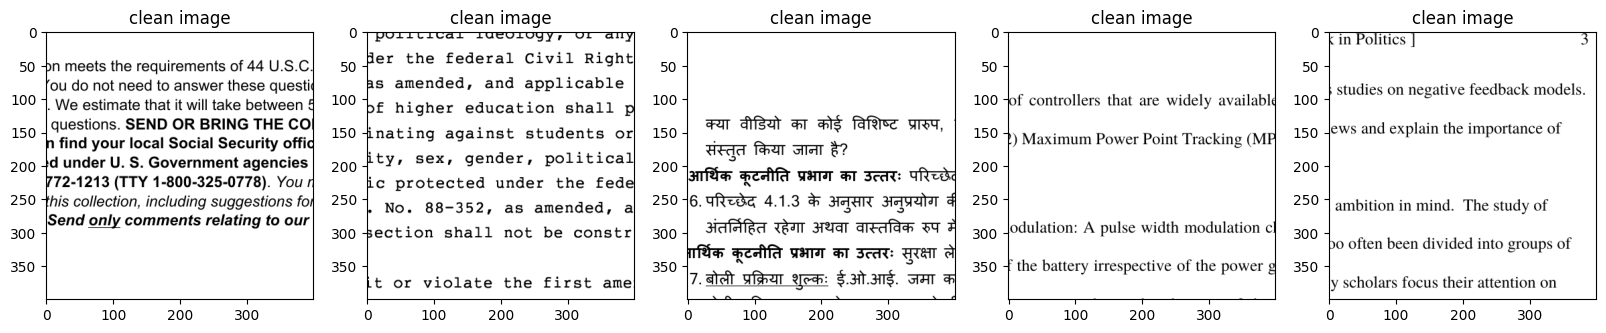

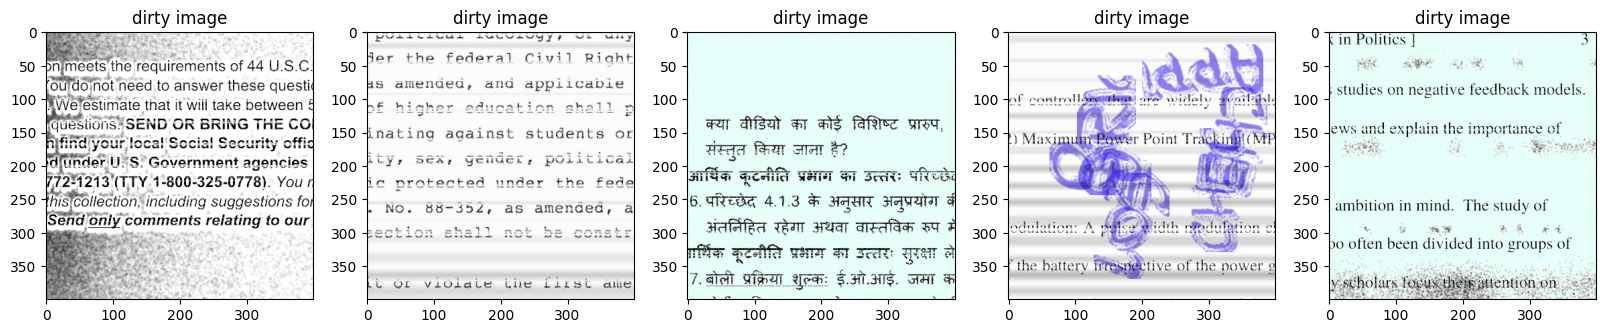

In [ ]:
# display some of the training images

plt.rcParams["figure.figsize"] = (20,20)
# clean
for image in train_images:
    plt.figure()
    for i in range(image[0].shape[0]): 
        plt.subplot(1,5,i+1)
        plt.imshow(image[0][i]/255, cmap="gray")
        plt.title("clean image")
        if i>=4:
            break
    break
# dirty
for image in train_images:
    if image[1][0] == 1:
        plt.figure()
        for i in range(image[0].shape[0]): 
            plt.subplot(1,5,i+1)
            plt.imshow(image[0][i]/255, cmap="gray")
            plt.title("dirty image")
            if i>=4:
                break
        break

9. We are using Resnet in the transfer learning process. In Tensorflow framework, we can import it by using `tf.keras.applications.ResNet152`. The model parameters are freezed by setting `layer.trainable = False`. Then, a new fully connected is added to train the model with new data. 

In [ ]:
# transfer learning using resnet

pretrained_model = tf.keras.applications.ResNet152(weights = 'imagenet', include_top = False, input_shape = (400,400,3))

for layer in pretrained_model.layers:
    layer.trainable = False

x = layers.Flatten()(pretrained_model.output)
x = layers.Dense(1000, activation='relu')(x)
predictions = layers.Dense(1, activation = 'sigmoid')(x)

model = Model(inputs = pretrained_model.input, outputs = predictions)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='binary_crossentropy',metrics = ['accuracy'])



234698864/234698864 [==============================] - 1s 0us/step


10. Then, we add an early stopping instance and add it into the training process.

In [ ]:
# train model
callback = EarlyStopping(monitor='val_loss', patience=10)
train_history = model.fit(train_images, validation_data = validate_images, epochs=epochs, callbacks=[callback], verbose=1)

Epoch 1/60
42/42 [==============================] - 316s 7s/step - loss: 99.2728 - accuracy: 0.8115 - val_loss: 21.5744 - val_accuracy: 0.5000
Epoch 2/60
42/42 [==============================] - 44s 1s/step - loss: 10.6968 - accuracy: 0.1557 - val_loss: 0.6909 - val_accuracy: 0.5103
Epoch 3/60
42/42 [==============================] - 43s 1s/step - loss: 0.6918 - accuracy: 0.5061 - val_loss: 0.6900 - val_accuracy: 0.5172
Epoch 4/60
42/42 [==============================] - 51s 1s/step - loss: 0.6876 - accuracy: 0.5198 - val_loss: 0.6769 - val_accuracy: 0.5466
Epoch 5/60
42/42 [==============================] - 44s 1s/step - loss: 0.6712 - accuracy: 0.5534 - val_loss: 0.6422 - val_accuracy: 0.6052
Epoch 6/60
42/42 [==============================] - 44s 1s/step - loss: 0.6121 - accuracy: 0.6748 - val_loss: 0.5529 - val_accuracy: 0.7690
Epoch 7/60
42/42 [==============================] - 44s 1s/step - loss: 0.4841 - accuracy: 0.8626 - val_loss: 0.4853 - val_accuracy: 0.8793
Epoch 8/60
42/42

11. Once the training is done, loss curve is plotted.

(0.0, 1.0)

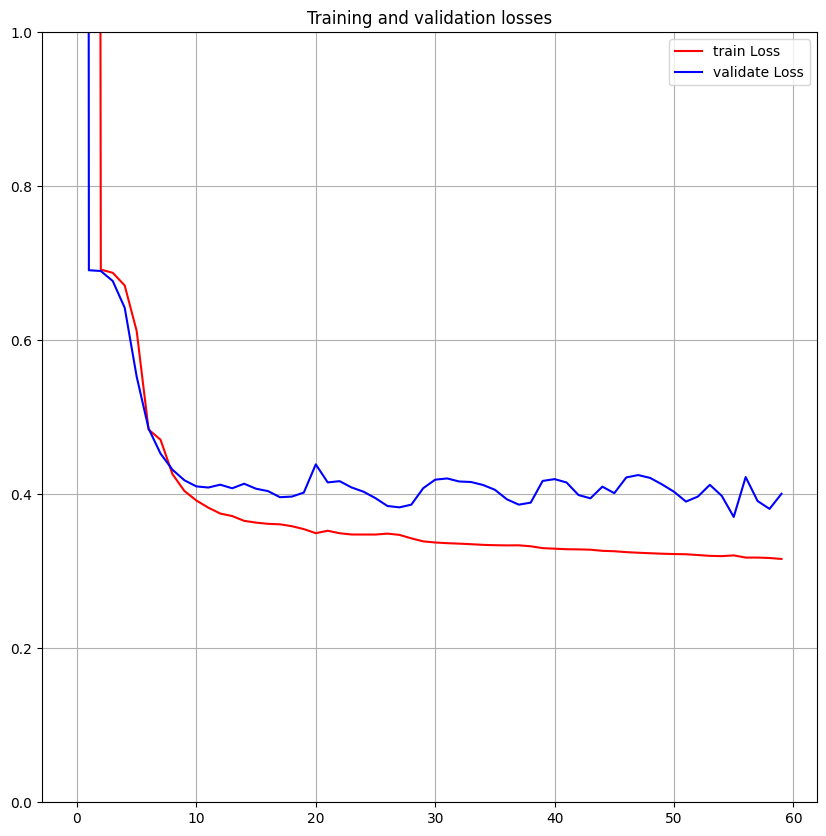

In [ ]:
# plot training curve

plt.rcParams["figure.figsize"] = (10,10)
train_losses = train_history.history['loss']
validate_losses = train_history.history['val_loss']
accuracy = train_history.history['accuracy']

x_train = [i for i in range(len(train_losses))]
x_validate = [i for i in range(len(validate_losses))]

plt.figure()
plt.grid()
plt.plot(x_train, train_losses, "red", label='train Loss')
plt.plot(x_validate, validate_losses, "blue", label='validate Loss')
plt.title("Training and validation losses")
plt.legend(loc="upper right")
plt.ylim(0, 1)

12. The last step is to test the trained model. The score the prediction is set at 0.5, so that any score > 0.5 is dirty image, while any score < 0.5 is a clean image. From the results, We can see the model is doing pretty well.

In [ ]:
# predict testing images

predicted_labels = model.predict(test_images)

372/372 [==============================] - 17s 44ms/step


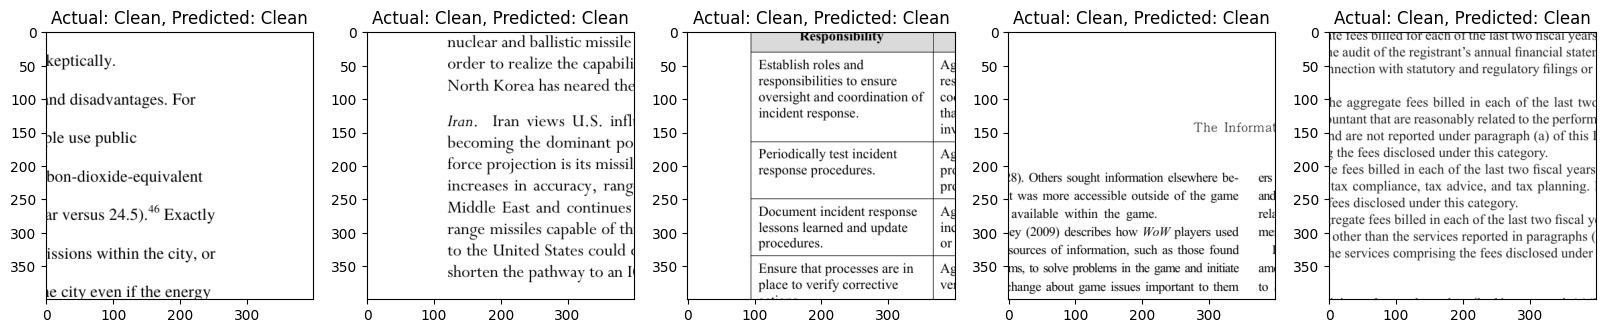

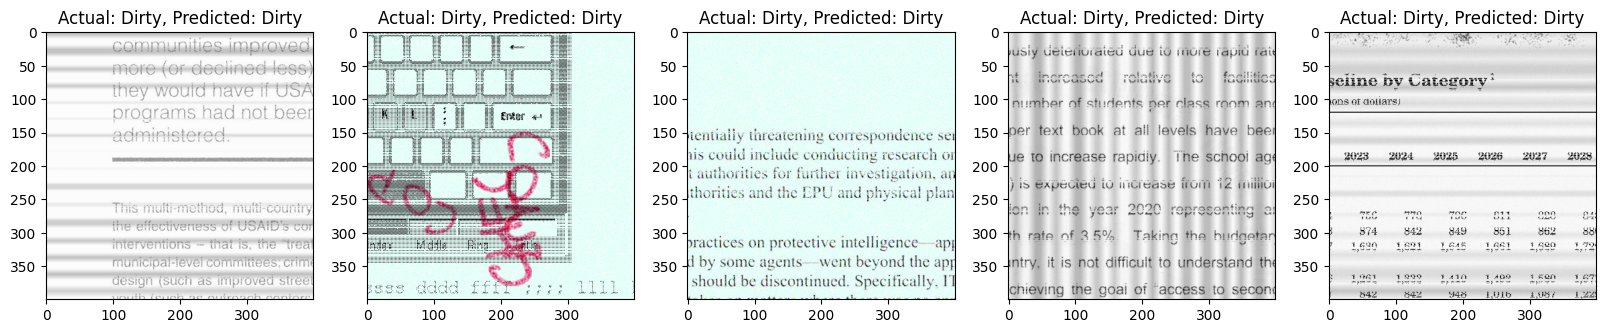

In [ ]:
# Display predicted results

plt.rcParams["figure.figsize"] = (20,20)
n_clean = 0
plt.figure()
for i, image in enumerate(test_images):
    if image[1] == 0:
        n_clean += 1
        plt.subplot(1,5,n_clean)
        plt.imshow(image[0][0]/255)
        if predicted_labels[i] < 0.5:
            predicted_label = "Clean"
        else:
            predicted_label = "Dirty"
        plt.title("Actual: Clean, Predicted: "+predicted_label)
        if n_clean >=5:
            break
    
plt.figure()
n_dirty = 0
for i, image in enumerate(test_images):
    if image[1] == 1:
        n_dirty += 1
        plt.subplot(1,5,n_dirty)
        plt.imshow(image[0][0]/255)
        if predicted_labels[i] < 0.5:
            predicted_label = "Clean"
        else:
            predicted_label = "Dirty"
        plt.title("Actual: Dirty, Predicted: "+predicted_label)
        if n_dirty >=5:
            break
